In [1]:
# %% [code] {"jupyter":{"outputs_hidden":false}}

%reset -f

import gc

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# check the tensorflow and GPU
print(f"Using Tensorflow {tf.__version__}")
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
print(
    f"Found GPU adn CPU.\nTensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}"
)


# import the datasets and check the files

import os

# path = "./phys591000-2023-final-project/"  # run on the local machine
# path = "/content/drive/Shareddrives/2023AI_final/2023AI_final/phys591000-2023-final-project/" # run on the google colab
path = "/kaggle/input/dune-neutrino/"  # Kaggle
if not os.path.isfile(path + "neutrino_test_data.npz") or os.path.isfile(
    path + "neutrino_train_data.npz"
):
    raise FileNotFoundError("test/train data was not found or is a directory")

# take out data from the datasets

data_train = np.load(path + "neutrino_training_data.npz")  # ideal data
data_test = np.load(path + "neutrino_test_data.npz")  # pseudo-exp data

name_train = data_train.files
name_test = data_test.files

(
    ve_train,
    vebar_train,
    vu_train,
    vubar_train,
    theta23_train,
    delta_train,
    ldm_train,
) = map(lambda n: data_train[n], name_train)
ve_test, vebar_test, vu_test, vubar_test = map(lambda n: data_test[n], name_test)


# create train and test data
noise_ve    = 10 * np.random.normal(0, 1, size=ve_train.shape)
noise_vebar = 3 * np.random.normal(0, 1, size=vebar_train.shape)
noise_vu    = 30 * np.random.normal(0, 1, size=vu_train.shape)
noise_vubar = 20 * np.random.normal(0, 1, size=vubar_train.shape)

X_train = np.stack((ve_train+noise_ve, vebar_train+noise_vebar, vu_train+noise_vu, vubar_train+noise_vubar), axis=-1)
Y_train = np.stack((theta23_train, delta_train, ldm_train), axis=-1)
# X_test = np.stack((ve_test, vebar_test, vu_test, vubar_test), axis=-1)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Using Tensorflow 2.12.0
Found GPU adn CPU.
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# [X] normalize training data to [0,1]
x_train_NH = X_train[ldm_train > 0]
print(f"Before normalized, the shape of x_train: {x_train_NH.shape}")
v_max = np.max(x_train_NH)
v_min = np.min(x_train_NH)
print(f"X-train normalized factors (v_max, v_min) = ({v_max}, {v_min})")
x_train_NH_norm = (x_train_NH - v_min) / (v_max - v_min)
print(f"After normalized, the shape of x_train: {x_train_NH_norm.shape}")

# [Y] normalize training label to [0,1] --> using sine function 
y_train_NH = Y_train[:, 1][ldm_train > 0]
print(f"Before normalized, the shape of y_train: {y_train_NH.shape}")
# v_max = np.max(y_train_NH)
# v_min = np.min(y_train_NH)
y_train_NH_norm = np.sin(y_train_NH * np.pi/180) # degree -> rad
print(f"Y-train normalized factors (v_max, v_min) = ({np.max(y_train_NH_norm)}, {np.min(y_train_NH_norm)})")
print(f"After normalized, the shape of y_train: {y_train_NH_norm.shape}")

# clear unused variables
del (
    X_train,
    Y_train,
    ve_train,
    vebar_train,
    vu_train,
    vubar_train,
    theta23_train,
    delta_train,
    ldm_train,
    ve_test,
    vebar_test,
    vu_test,
    vubar_test,
)
gc.collect()

Before normalized, the shape of x_train: (500027, 65, 4)
X-train normalized factors (v_max, v_min) = (2043.6581892930526, -68.5766233404749)
After normalized, the shape of x_train: (500027, 65, 4)
Before normalized, the shape of y_train: (500027,)
Y-train normalized factors (v_max, v_min) = (0.9999999999253686, -1.0)
After normalized, the shape of y_train: (500027,)


121

In [3]:

# create validation data
from sklearn.model_selection import train_test_split

# split the training dataset into training and validation, with test_size = 0.2
tf.random.set_seed(2023)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_NH_norm,
    y_train_NH_norm,
    random_state=10,
    test_size=0.2,
    shuffle=True,
)
# clear unused variables
del x_train_NH_norm, y_train_NH_norm

Model: "reg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 65, 4, 1)]        0         
                                                                 
 conv2d (Conv2D)             (None, 33, 2, 32)         544       
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 1, 32)         16416     
                                                                 
 re_lu (ReLU)                (None, 17, 1, 32)         0         
                                                                 
 batch_normalization (BatchN  (None, 17, 1, 32)        128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 1, 32)         0         
 )                                                             

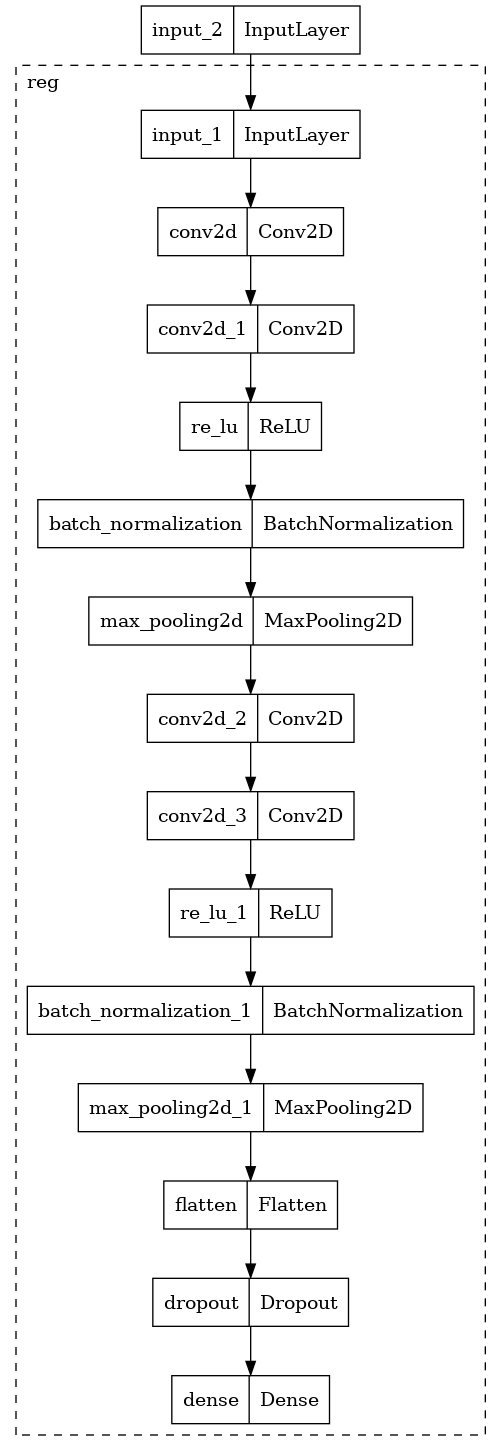

In [4]:
from tensorflow.keras import Input, Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    AveragePooling2D,
    MaxPooling2D,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Layer,
    LeakyReLU,
    ReLU,
    Reshape,
)
from keras.utils import plot_model


def create_model(input_dim):
    inputs = Input(shape=input_dim)
    x = Conv2D(32, kernel_size=4, strides=2, padding="same", activation="relu")(inputs)
    x = Conv2D(32, kernel_size=4, strides=2, padding="same")(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(padding="same")(x)
    x = Conv2D(64, kernel_size=2, strides=1, padding="same", activation="relu")(x)
    x = Conv2D(64, kernel_size=2, strides=1, padding="same")(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(padding="same")(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
#     x = Dense(8, activation="relu")(x)  
    x = Dense(1, activation="tanh")(x)  

    model = Model(inputs, x, name="reg")
    model.summary()

    model_inputs = Input(shape=input_dim)
    model_outputs = model(model_inputs)
    output_model = Model(inputs=model_inputs, outputs=model_outputs)
    return output_model


from tensorflow.keras.optimizers import Adam

# Declare the model
model = create_model(
    input_dim=(x_train.shape[1], x_train.shape[2], 1)
)

# Compile the model
model.compile(optimizer=Adam(1e-5), loss="huber")
plot_model(model, to_file='reg_model.png', expand_nested=True)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

# train
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    epochs=512,
    batch_size=96,
    callbacks=[early_stopping],
    shuffle=True,
    verbose=2,
)

Epoch 1/512
4167/4167 - 29s - loss: 0.0871 - val_loss: 0.0197 - 29s/epoch - 7ms/step
Epoch 2/512
4167/4167 - 19s - loss: 0.0149 - val_loss: 0.0105 - 19s/epoch - 5ms/step
Epoch 3/512
4167/4167 - 19s - loss: 0.0108 - val_loss: 0.0097 - 19s/epoch - 4ms/step
Epoch 4/512
4167/4167 - 20s - loss: 0.0092 - val_loss: 0.0078 - 20s/epoch - 5ms/step
Epoch 5/512
4167/4167 - 20s - loss: 0.0079 - val_loss: 0.0063 - 20s/epoch - 5ms/step
Epoch 6/512
4167/4167 - 19s - loss: 0.0072 - val_loss: 0.0067 - 19s/epoch - 4ms/step
Epoch 7/512
4167/4167 - 20s - loss: 0.0067 - val_loss: 0.0056 - 20s/epoch - 5ms/step
Epoch 8/512
4167/4167 - 19s - loss: 0.0065 - val_loss: 0.0070 - 19s/epoch - 5ms/step
Epoch 9/512
4167/4167 - 19s - loss: 0.0063 - val_loss: 0.0057 - 19s/epoch - 5ms/step
Epoch 10/512
4167/4167 - 19s - loss: 0.0062 - val_loss: 0.0066 - 19s/epoch - 5ms/step
Epoch 11/512
4167/4167 - 19s - loss: 0.0061 - val_loss: 0.0053 - 19s/epoch - 5ms/step
Epoch 12/512
4167/4167 - 19s - loss: 0.0060 - val_loss: 0.0053 

3126/3126 [==============================] - 6s 2ms/step


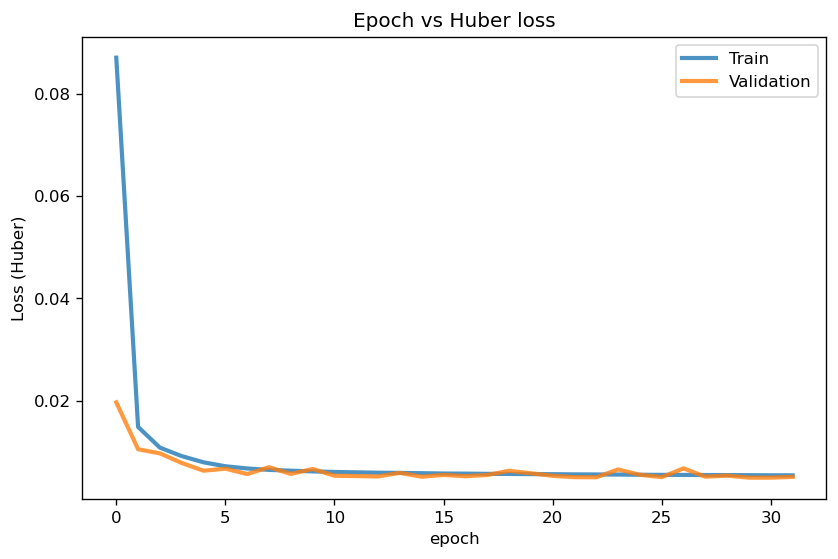

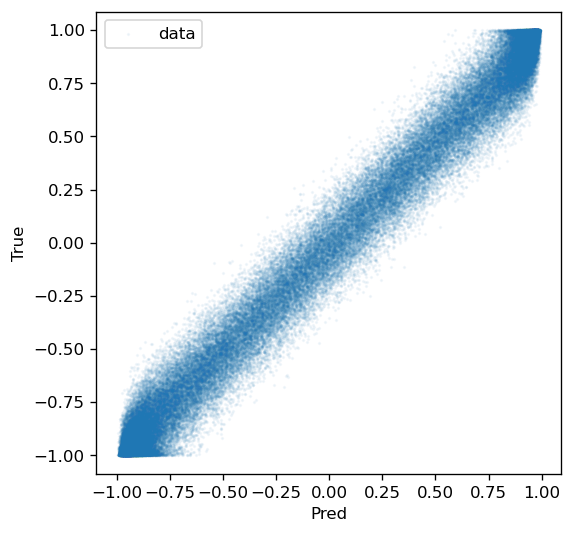

In [6]:
# check the loss function
fig = plt.figure(figsize=(8, 5), dpi=120)
history = model.history.history
plt.plot(history["loss"], lw=2.5, label="Train", alpha=0.8)
plt.plot(history["val_loss"], lw=2.5, label="Validation", alpha=0.8)
# plt.semilogy()
plt.title("Epoch vs Huber loss")
plt.xlabel("epoch")
plt.ylabel("Loss (Huber)")
plt.legend(loc="best")
plt.savefig("regression.png")
# plt.close()

# test predictions with scatter plot
x = model.predict(x_val)
fig = plt.figure(figsize=(5, 5), dpi=120)
plt.scatter(x, y_val, s=1, alpha=0.05, label="data")
plt.legend(loc="best")
plt.xlabel("Pred")
plt.ylabel("True")
plt.axis('equal')

# save model
model.save("./regression.h5")